# Credit Modeller - Home Task 

> Robert Tarasevic 2021.08.04


## Problem
Predicting and preventing loan defaults is very important task in finances, therefore in this notebook I'm going to build machine learning model for loan default classification and default probability estimation.

#### This work consists of the following parts:
1. Data exploration, including visualisations and finding relationships between the target variable and independent variables.
2. Data cleaning and processing.
3. Computing and plotting lifetime loss and paydown balance curves.
4. Customer risk profiling at the point of acquisition.
5. Feature engineering.
6. Features selection using statistical methods.
7. Classification model building.
8. Model evaluation.
9. Results.

## Data

*Default Data dictionary:*
*	UID - customer ID
*   Recordnumber - customer’s loan id
*	Dval - default value
*	Dmon - month on books when default was registered


*Loan attributes data dictionary:*
*	UID - customer ID
*	Recordnumber - customer’s loan id
*	Openbalance - loan opening balance
*	Accstartdate - account opening date
*	First_month - month when customer first logged into online servicing
*	Last_month - month when customer last logged into online servicing
*	Repayperiod - original loan term
*	Searchdate - date when customer data was uploaded to the database


*Quality data dictionary:*
*	UID - customer ID
*	Score - acquisition score
*	Class - customer type



We can see that a limited amount of data on people's loans is available, so I had to create additional features myself:

* ACTIVE_CREDIT - Does the consumer already have an active loan
* PAST_DEFAULT - Whether the consumer has previously defaulted on a loan
* OPEN_BALANCE_CAT - Open balance divided into 4 equal categories (small, medium, large, very large)
* OPEN_BALANCE_TERM_RATIO - logarithm of monthly loan payments
* REPAY_DATE - Full loan settlement date
* MONTHLY_PAYMENT - amount that customer pays each month for loan
* D_DATE - Date when default registered

#### Required packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# standard packages
import pandas as pd
import numpy as np

# visualization and dimension reduction
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# packages for working with dates timestamps data
from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Non numeric values encoding, data scaling and clustering
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Statistical tests
from scipy.stats import f_oneway
from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency 

# Classification models and its performance evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

# Data loading, cleaning and exploration

This as every project starts with data loading and an initial overview.

In [ ]:
d_default = pd.read_csv("/content/drive/MyDrive/credit_modeling/data/Loan_Defaults.csv")
d_attributes = pd.read_csv("/content/drive/MyDrive/credit_modeling/data/Loan_Attributes.csv")
d_quality = pd.read_csv("/content/drive/MyDrive/credit_modeling/data/Client_Risk_Quality.csv")

d_default.shape, d_attributes.shape, d_quality.shape # check shape of each table

((20000, 4), (58687, 8), (16347, 3))

In [ ]:
print("Columns in tables\n\nDefault table:\t\t{}\nAttributes table:\t{}\nQuality table:\t\t{}".format(d_default.columns.to_list(), d_attributes.columns.to_list(), d_quality.columns.to_list()))

Columns in tables

Default table:		['UID', 'RECORDNUMBER', 'DVAL', 'DMON']
Attributes table:	['UID', 'RECORDNUMBER', 'OPENBALANCE', 'ACCSTARTDATE', 'FIRST_MONTH', 'LAST_MONTH', 'REPAYPERIOD', 'SEARCHDATE']
Quality table:		['UID', 'SCORE', 'CLASS']


In [ ]:
print(d_default.UID.nunique(), d_attributes.UID.nunique(), d_quality.UID.nunique()) # check number of unique customers in each table

16347 16347 16347


It is easy to see that all given tables have common columns (*UID*, *RECORDNUMBER*). Lets merge them on common columns and keep only those records that are in *Loan Defaults* table, because these records have information about defaults.

In [ ]:
df = pd.merge(d_default, d_attributes, how='inner', on=['UID', 'RECORDNUMBER']) # merging default and attributes table on two common columns
df = pd.merge(df, d_quality, on='UID') # merging quality table on customer id (UID) column
df.head() # merged table overview

,UID,RECORDNUMBER,DVAL,DMON,OPENBALANCE,ACCSTARTDATE,FIRST_MONTH,LAST_MONTH,REPAYPERIOD,SEARCHDATE,SCORE,CLASS
0,2a08b1c1-504b-4178-8c3f-942aa09c7732,8,70.0,6.0,50.0,2017-01-21,2017-01-01,2018-09-01,6.0,20180910,507.0,STANDARD
1,2a08b1c1-504b-4178-8c3f-942aa09c7732,6,203.0,6.0,150.0,2017-01-07,2017-01-01,2018-09-01,6.0,20180910,507.0,STANDARD
2,2a08b1c1-504b-4178-8c3f-942aa09c7732,7,56.0,6.0,50.0,2017-01-11,2017-01-01,2018-09-01,6.0,20180910,507.0,STANDARD
3,039b68a8-0953-484f-a14a-0e1e78ef7794,7,999.0,5.0,800.0,2016-07-23,2016-08-01,2018-06-01,11.0,20180630,518.0,STANDARD
4,225b6f92-6c66-45c1-bb82-7ed89aad9619,8,7859.0,27.0,12000.0,2012-11-13,2013-08-01,2019-07-01,60.0,20190717,599.0,STANDARD


Lets have a look at missing values in merged dataframe.
We can see, that *OPENBALANCE*, *ACCSTARTDATE* and *REPAYPERIOD* have missing some values.

These variables are important in building a loan default classification model and without additional information it would be incorrect to try to recover these missing values by changing with mean, median or estimating the missing value by distance metrics. So I we will simply remove those records

In [ ]:
df.isnull().sum()

UID                 0
RECORDNUMBER        0
DVAL            10000
DMON            10000
OPENBALANCE       793
ACCSTARTDATE        2
FIRST_MONTH         0
LAST_MONTH          0
REPAYPERIOD      1354
SEARCHDATE          0
SCORE               0
CLASS               0
dtype: int64

In [ ]:
df = df[df.REPAYPERIOD.notna()] # keep only records where REPAYPERIOD consists (because it have the most missing values)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18646 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   UID           18646 non-null  object 
 1   RECORDNUMBER  18646 non-null  int64  
 2   DVAL          8697 non-null   float64
 3   DMON          8697 non-null   float64
 4   OPENBALANCE   17888 non-null  float64
 5   ACCSTARTDATE  18644 non-null  object 
 6   FIRST_MONTH   18646 non-null  object 
 7   LAST_MONTH    18646 non-null  object 
 8   REPAYPERIOD   18646 non-null  float64
 9   SEARCHDATE    18646 non-null  int64  
 10  SCORE         18646 non-null  float64
 11  CLASS         18646 non-null  object 
dtypes: float64(5), int64(2), object(5)
memory usage: 1.8+ MB


In [ ]:
# Set target variable - default
df['DEFAULT'] = np.where(df.DVAL > 0, 'DEFAULT', 'GOOD')

## Filtering by loans term
It was mentioned in the assignment that bank is not interested in loans with a duration of less than 12 months and more than 60 months. 



> This could be based on the fact that customers taking out a loan with a duration of less than 12 months are less financially educated and often face financial difficulties, as a result of which they need to borrow money for daily expenses for a short period of time. Since the person is no longer able to manage his/her finances, it is very likely that he/she will not be able to repay the borrowed money on time. 

> As for loans longer than 60 months (5 years), they are less attractive because it is very difficult to predict for such a period, it is difficult to predict what the customer's financial situation will be or whether he or she will still be in a well-paid job, and, in the case of loans for new cars, it is often the case that the car's warranty will expire in 5 years or even less, which means a significant depreciation, and of course inflation..

We can see all this in the figure below. It clearly shows that loans with a duration of up to 12 months are significantly more likely to default.

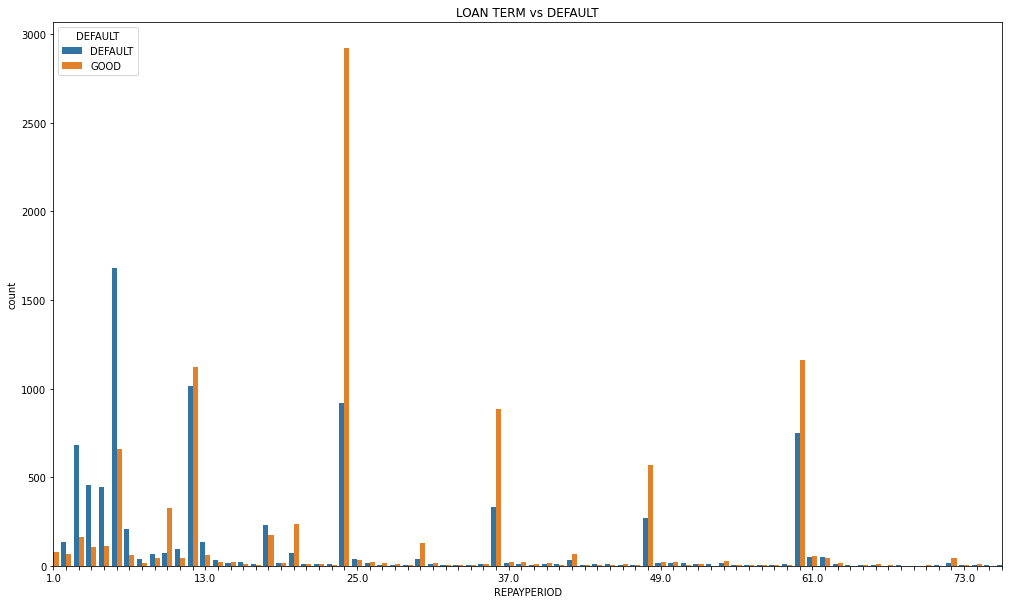

In [ ]:
plt.figure(figsize=(17,10))
plot = sns.countplot('REPAYPERIOD', hue='DEFAULT', data=df)
for i, label in enumerate(plot.get_xticklabels()):
    if i % 12 == 0:  # every 12th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plot.set_xlim(left=0, right=75)
plt.title("LOAN TERM vs DEFAULT")
plt.show()


In [ ]:
# filter out loans with period lower than 12 months or greater than 60 months
df = df[df.REPAYPERIOD.between(12, 60)]

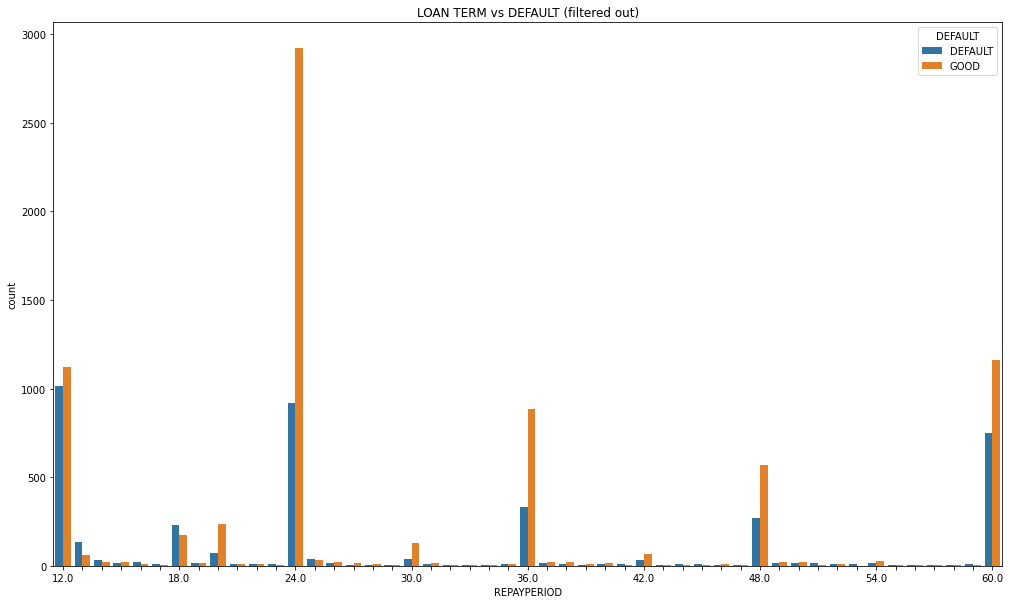

In [ ]:
plt.figure(figsize=(17,10))
plot = sns.countplot('REPAYPERIOD', hue='DEFAULT', data=df)
for i, label in enumerate(plot.get_xticklabels()):
    if i % 6 == 0:  # every 6th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.title("LOAN TERM vs DEFAULT (filtered out)")
plt.show()


Also provided dataset consist of loans that are active at the cut-off date of 2019-10-01. I'm going to filter out them because there is no guarantee that they will be paid on time. For these purpose I have created a function that is calculating repay or any other date by adding months to given date.

In [ ]:
# function for date calculation by adding term (in months)
def repay_date(date, repay_period):
    dt = datetime.strptime(str(date), '%Y-%m-%d')
    dt+= relativedelta(months=repay_period)
    
    return dt

In [ ]:
# create new column with repay date and filter out loans that are not finished yet (until 2019-10-01)
df['REPAY_DATE'] = df.apply(lambda x: repay_date(x.ACCSTARTDATE, x.REPAYPERIOD) 
                                    if pd.notnull(x.ACCSTARTDATE) else x.ACCSTARTDATE, axis=1)
df['REPAY_DATE'] = pd.to_datetime(df["REPAY_DATE"])

Let's check when the latest loan should be paid

In [ ]:
df.REPAY_DATE.max()

Timestamp('2024-09-18 00:00:00')

Filtering out loans that are active at the cut-off date

In [ ]:
df['REPAY_DATE'] = df["REPAY_DATE"].dt.date
df = df[df.REPAY_DATE < date(2019, 10, 1)]

As we can see, after filtration we have only those records where repay date is less than 2019-10-01

In [ ]:
df.REPAY_DATE.max()

datetime.date(2019, 9, 30)

Another variable that will be needed later is the date of default on the loan. We have the date the loan was taken out and the date (in months) after which the default was recorded. For these calculations we will use the function already written.

In [ ]:
# calculate default date based on loan starting date and DMON
df['D_DATE'] = df.apply(lambda x: repay_date(x.ACCSTARTDATE, x.DMON) if pd.notnull(x.DMON) else x.DMON, axis=1) # if loan is not defaulted (DMON == NaN), D_DATE = NaN
df['D_DATE'] = pd.to_datetime(df["D_DATE"]).dt.strftime('%Y-%m')

# change to datetime format
df['ACCSTARTDATE']=pd.to_datetime(df["ACCSTARTDATE"])

df.head()

,UID,RECORDNUMBER,DVAL,DMON,OPENBALANCE,ACCSTARTDATE,FIRST_MONTH,LAST_MONTH,REPAYPERIOD,SEARCHDATE,SCORE,CLASS,DEFAULT,REPAY_DATE,D_DATE
4,225b6f92-6c66-45c1-bb82-7ed89aad9619,8,7859.0,27.0,12000.0,2012-11-13,2013-08-01,2019-07-01,60.0,20190717,599.0,STANDARD,DEFAULT,2017-11-13,2015-02
5,d10af710-591d-458e-b81f-85fb99d9c5a8,9,2739.0,9.0,3000.0,2012-09-22,2012-09-01,2018-08-01,36.0,20180824,580.0,STANDARD,DEFAULT,2015-09-22,2013-06
6,d10af710-591d-458e-b81f-85fb99d9c5a8,10,2680.0,9.0,3000.0,2012-08-26,2012-09-01,2018-08-01,36.0,20180824,580.0,STANDARD,DEFAULT,2015-08-26,2013-05
7,6457c750-e7c0-4309-9ca3-8dd2ddbabbc0,8,NaN,NaN,1741.0,2016-05-09,2016-06-01,2019-06-01,36.0,20190713,662.0,STANDARD,GOOD,2019-05-09,NaN
8,d09b7e2a-b602-45bb-9882-e4af4d0e07c2,14,221.0,7.0,221.0,2017-06-29,2018-10-01,2019-06-01,12.0,20190608,512.0,PREMIUM,DEFAULT,2018-06-29,2018-01


# Feature engineering
Since we have a limited dataset, we need to create at least a few variables that can help us build the final classification model.

After analysing the data, I have noticed that some customers who have not repaid one loan have taken out another loan, and there are also customers who have already had difficulties repaying loans in the past.

In [ ]:
# active_credit - determine whether the customer has active loans at the time of the request
# already_defaulted - determining whether the customer has had defaulted loans in the past

def active_credit(x, df=df):
  uid = x.UID
  acc_start = x.ACCSTARTDATE
  repay_date = x.REPAY_DATE
  
  if len(df[df.UID==uid])>1:
    for _, row in df[df.UID==uid].iterrows(): # iterate through all customer loans
      if (row.REPAY_DATE > acc_start and acc_start != row.ACCSTARTDATE):
        return 'HAVE LOAN' # Customer already have active loan when taking another loan
      else:
        return 'CLEAR' # Customer havent any active loans
  else:
    return 'CLEAR' # Customer havent any active loans
  

def already_defaulted(x, df=df):
  uid = x.UID
  acc_start = x.ACCSTARTDATE
  dval = pd.notna(x.DVAL)

  if len(df[df.UID==uid])>1:
    for _, row in df[df.UID==uid].iterrows(): # iterate through all customer loans
      if (dval and acc_start != row.ACCSTARTDATE):
        return 'DEFAULTED' # Customer already have had default
      else:
        return 'CLEAR' # Customer didnt have defaults
  else:
    return 'CLEAR' # Customer didnt have defaults


# function for monthly payment calculation
def ob_term_ratio(row):
  if row.OPENBALANCE > 0:
    ratio = row.OPENBALANCE/row.REPAYPERIOD
    return round(ratio,2)
  else:
    return 0

In [ ]:
df['ACTIVE_CREDIT'] = df.apply(active_credit, axis=1)
df['PAST_DEFAULT'] = df.apply(already_defaulted, axis=1)
df['MONTHLY_PAYMENT'] = df.apply(ob_term_ratio, axis=1)
df = df[df.OPENBALANCE.notnull()]

Lets check how OPENBALANCE feature is distributed over all its range (from min to max) 

Text(0.5, 1.0, 'ECDF')

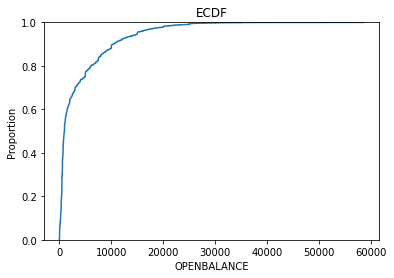

In [ ]:
sns.ecdfplot(df.OPENBALANCE)
plt.title("ECDF")

From figure above we can see that OPENBALANCE variable is very skewed and there is some small values, lets take filter out them and keep only those records which are greater than 5th percentile and lower than 95th percentile.

 lower:	71.0
 upper:	15000.0


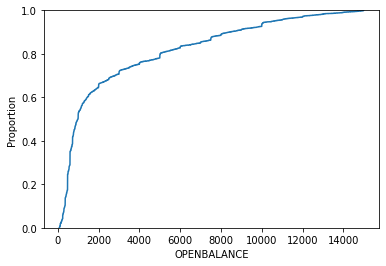

In [ ]:
lower = np.percentile(df.OPENBALANCE, 5)
upper = np.percentile(df.OPENBALANCE, 95)
print(' lower:\t{}\n upper:\t{}'.format(lower, upper))

df = df[df.OPENBALANCE > lower]
df = df[df.OPENBALANCE < upper]

sns.ecdfplot(df.OPENBALANCE)


To make the data easier to understand and more intuitive, let's make the continuous variables into categorical variables. For that I'm going to use pandas function cut.

In [ ]:
df['OPEN_BALANCE_CAT'] = pd.cut(df.OPENBALANCE, 4, labels=['SMALL', 'MEDIUM', 'LARGE', 'VERY LARGE']) # cut open balance into 4 equal parts
df['REPAYPERIOD'] = df['REPAYPERIOD'].apply(lambda x: str(x)) # change repay period to object type
df['RECORDNUMBER'] = df['RECORDNUMBER'].apply(lambda x: str(x)) # change record number to object type
df['OPEN_BALANCE_CAT'] = df['OPEN_BALANCE_CAT'].apply(lambda x: str(x)) # change record number to object type
df.head()

,UID,RECORDNUMBER,DVAL,DMON,OPENBALANCE,ACCSTARTDATE,FIRST_MONTH,LAST_MONTH,REPAYPERIOD,SEARCHDATE,SCORE,CLASS,DEFAULT,REPAY_DATE,D_DATE,ACTIVE_CREDIT,PAST_DEFAULT,MONTHLY_PAYMENT,OPEN_BALANCE_CAT
4,225b6f92-6c66-45c1-bb82-7ed89aad9619,8,7859.0,27.0,12000.0,2012-11-13,2013-08-01,2019-07-01,60.0,20190717,599.0,STANDARD,DEFAULT,2017-11-13,2015-02,CLEAR,CLEAR,200.00,VERY LARGE
5,d10af710-591d-458e-b81f-85fb99d9c5a8,9,2739.0,9.0,3000.0,2012-09-22,2012-09-01,2018-08-01,36.0,20180824,580.0,STANDARD,DEFAULT,2015-09-22,2013-06,CLEAR,CLEAR,83.33,SMALL
6,d10af710-591d-458e-b81f-85fb99d9c5a8,10,2680.0,9.0,3000.0,2012-08-26,2012-09-01,2018-08-01,36.0,20180824,580.0,STANDARD,DEFAULT,2015-08-26,2013-05,HAVE LOAN,DEFAULTED,83.33,SMALL
7,6457c750-e7c0-4309-9ca3-8dd2ddbabbc0,8,NaN,NaN,1741.0,2016-05-09,2016-06-01,2019-06-01,36.0,20190713,662.0,STANDARD,GOOD,2019-05-09,NaN,CLEAR,CLEAR,48.36,SMALL
8,d09b7e2a-b602-45bb-9882-e4af4d0e07c2,14,221.0,7.0,221.0,2017-06-29,2018-10-01,2019-06-01,12.0,20190608,512.0,PREMIUM,DEFAULT,2018-06-29,2018-01,CLEAR,CLEAR,18.42,SMALL


## Categorical predictor against target variable
Lets check grouepd bar plots for each categorical predictor (variable) against target variable - DEFAULT

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7024 entries, 4 to 19997
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   UID               7024 non-null   object        
 1   RECORDNUMBER      7024 non-null   object        
 2   DVAL              2591 non-null   float64       
 3   DMON              2591 non-null   float64       
 4   OPENBALANCE       7024 non-null   float64       
 5   ACCSTARTDATE      7024 non-null   datetime64[ns]
 6   FIRST_MONTH       7024 non-null   object        
 7   LAST_MONTH        7024 non-null   object        
 8   REPAYPERIOD       7024 non-null   object        
 9   SEARCHDATE        7024 non-null   int64         
 10  SCORE             7024 non-null   float64       
 11  CLASS             7024 non-null   object        
 12  DEFAULT           7024 non-null   object        
 13  REPAY_DATE        7024 non-null   object        
 14  D_DATE            2591 

In [ ]:
Y = df.DEFAULT
df_cat = df.drop(['UID', 'FIRST_MONTH', 'LAST_MONTH', 'DEFAULT', 'REPAY_DATE', 'D_DATE'], axis=1).select_dtypes(include=['object', 'category']) # select variables with dtype='object' except...
CategoricalColsList=df_cat.columns.to_list()

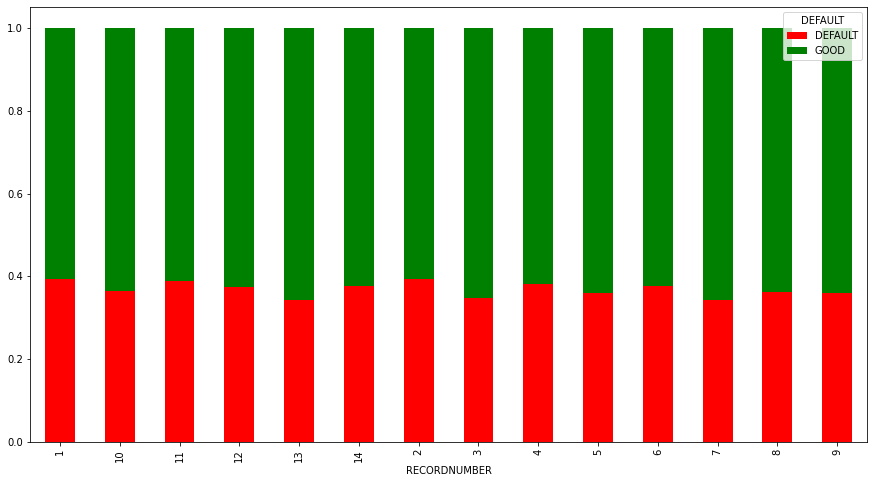

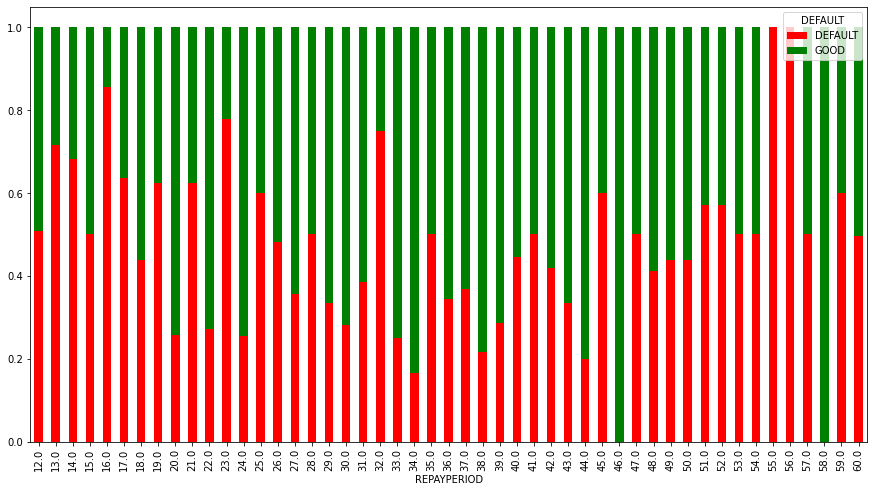

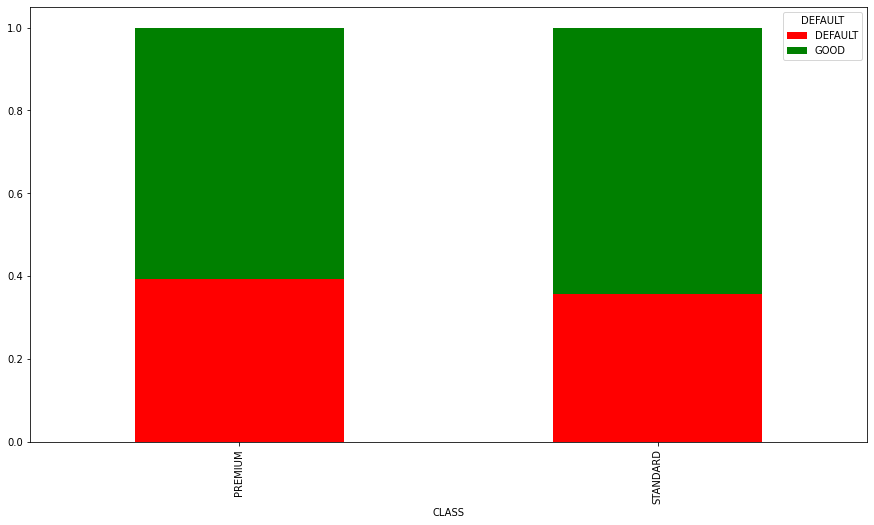

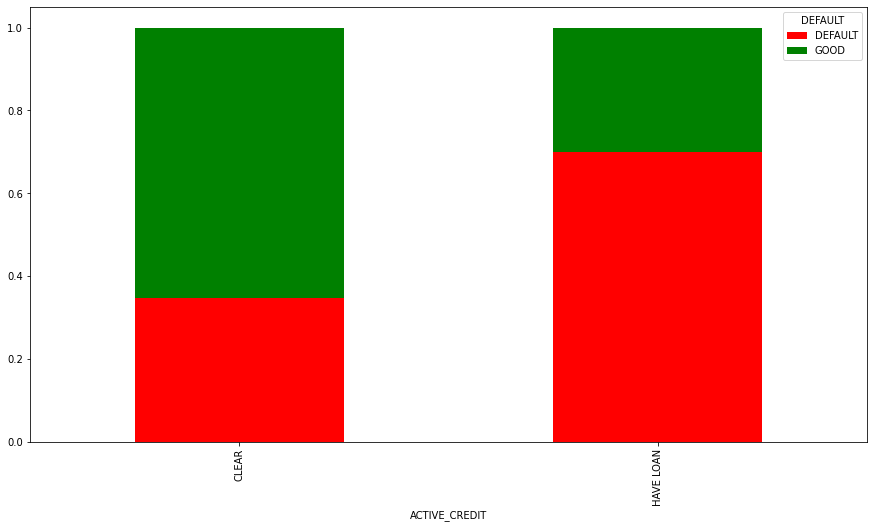

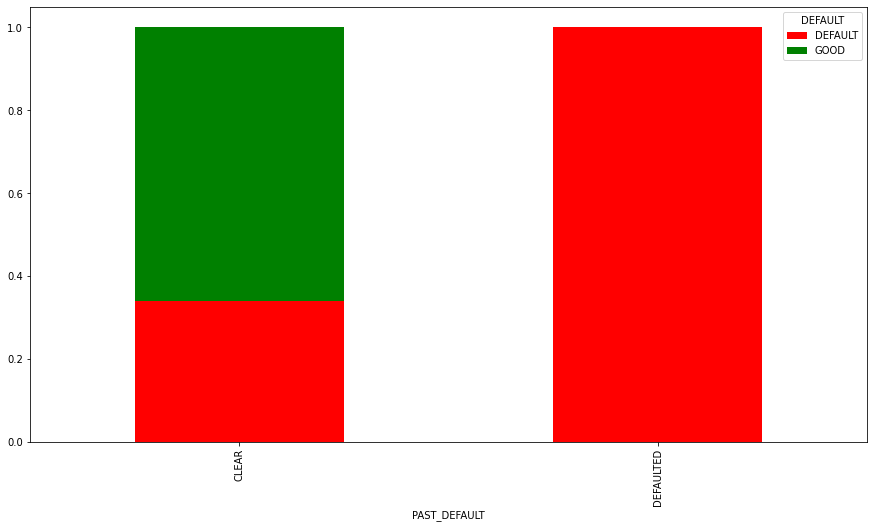

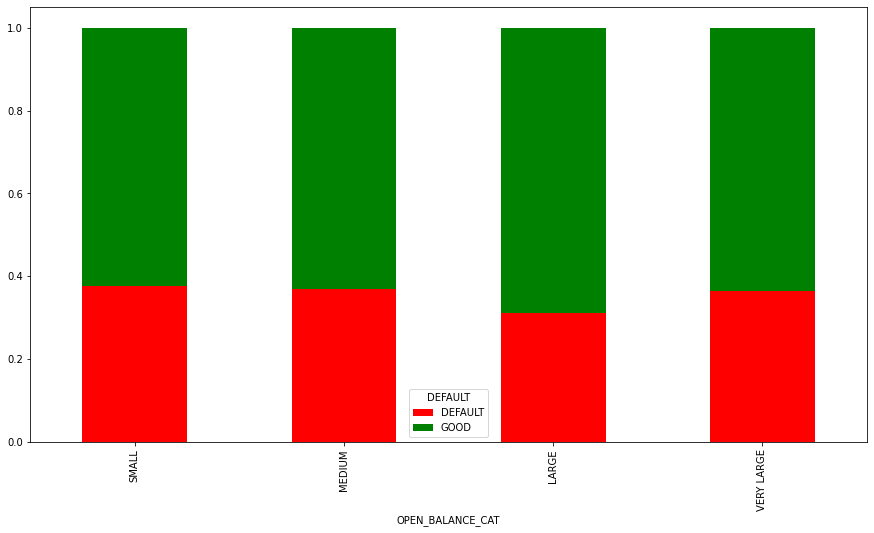

In [ ]:
for index,col in enumerate(CategoricalColsList, start=1):
    data = pd.crosstab(df_cat[col],Y)
    data.div(data.sum(axis=1).astype(float), axis=0).plot(color=['red', 'green'], kind="bar", stacked=True, figsize=(15,8))

Looking at the bar charts above, we can make the following conclusions:
1. There is no significant difference between PREMIUM and STANDARD customers.
2. Customers who take out a second loan without repaying their first loan are likely to default
3. Customers who have previously failed to repay their loan on time will also fail to repay their next loan.
4. Customers who take out a larger loan are more likely to default.
5. customers who take out a loan for around 24-48 months are the least likely to default

## Chi-Squared Test
The Chi-Square Test of Independence determines whether there is an association between categorical variables, in our case, we want to determine if there is relationship between our categorical features and target variable - DEFAULT.

* **If p-value <= alpha**: significant result, reject null hypothesis (H0), dependent.
* **If p-value > alpha**: not significant result, fail to reject null hypothesis (H0), independent.

alpha = 0.05

In [ ]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the dataset to calculate chi-statistic with the target variable
for column in df_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(Y, df_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,REPAYPERIOD,0.000000
1,ACTIVE_CREDIT,0.000000
2,PAST_DEFAULT,0.000000
3,CLASS,0.002629
4,OPEN_BALANCE_CAT,0.019332
5,RECORDNUMBER,0.807532


The Chi-Square Test allows us to make the following conclusions:

* all categorical variables except RECORDNUMBER have a relationship with the target variable DEFAULT

## Continuous predictor agains target variable

In [ ]:
df_num = df.drop(['UID', 'FIRST_MONTH', 'LAST_MONTH', 'DEFAULT', 'REPAY_DATE', 'D_DATE', 'DVAL', 'DMON'], axis=1).select_dtypes(include=['float64']) # select variables with dtype='float64' except...
df_num.head()

,OPENBALANCE,SCORE,MONTHLY_PAYMENT
4,12000.0,599.0,200.00
5,3000.0,580.0,83.33
6,3000.0,580.0,83.33
7,1741.0,662.0,48.36
8,221.0,512.0,18.42


In [ ]:
concat_data = pd.concat([df_num,Y],axis=1)

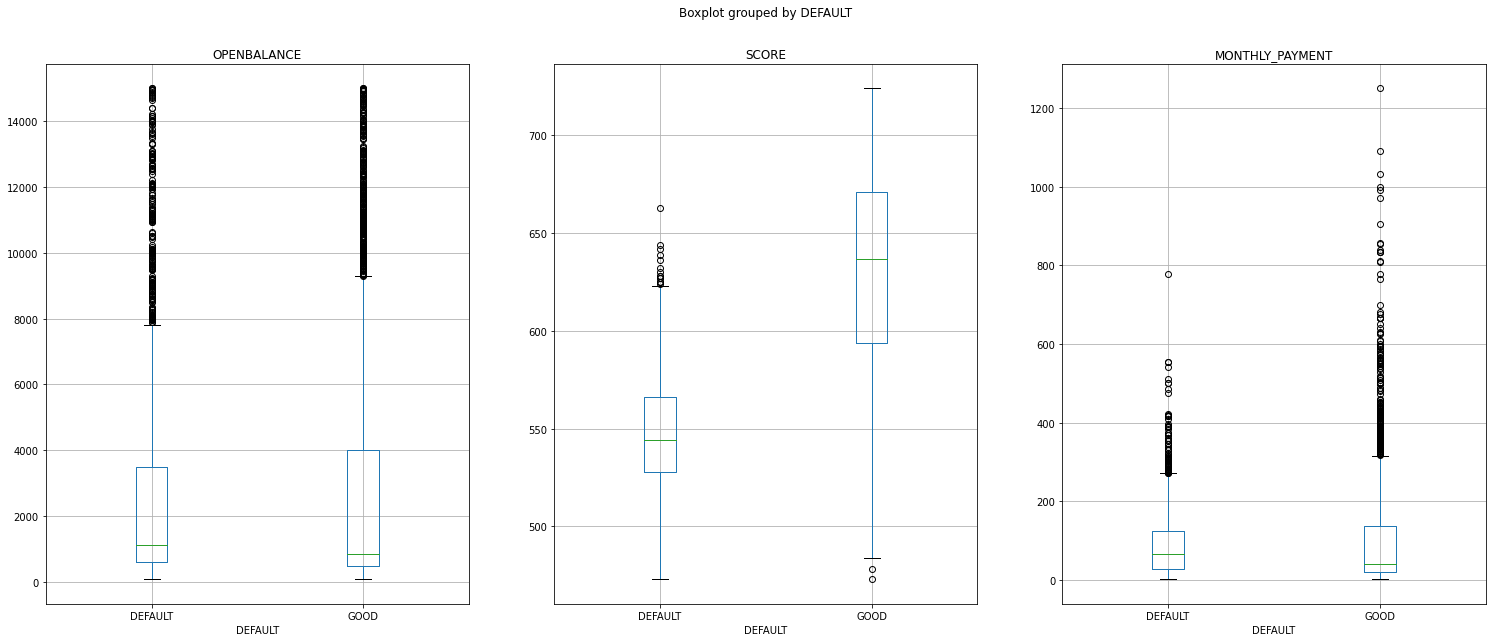

In [ ]:
ContinuousColsList=df_num.columns.to_list()


fig, PlotCanvas=plt.subplots(nrows=1, ncols=len(ContinuousColsList), figsize=(25,10))

# Creating box plots for each continuous predictor against the Target Variable (DEFAULT)
for PredictorCol , i in zip(ContinuousColsList, range(len(ContinuousColsList))):
    concat_data.boxplot(column=PredictorCol, by='DEFAULT', figsize=(5,5), vert=True, ax=PlotCanvas[i])

We can clearly see the differences between the groups according to the SCORE variable, but for the other variables we can't tell from the boxplot, so we'll perform an additional ANOVA test, and at the same time we'll select the significant variables.

## ANOVA
Analysis of variance (ANOVA) is performed to check if there is any relationship between the given continuous and categorical variable.

* Assumption(H0): There is NO relation between the given variables (i.e. The average(mean) values of the numeric Predictor variable is same for all the groups in the categorical Target variable)
* ANOVA Test result: Probability of H0 being true

In [ ]:
# Defining a function to find the statistical relationship with all the categorical variables
def FunctionAnova(inpData, TargetVariable, ContinuousPredictorList):
    from scipy.stats import f_oneway
    
    # Creating an empty list of final selected predictors
    SelectedPredictors=[]
    
    print('##### ANOVA Results ##### \n')
    for predictor in ContinuousPredictorList:
        CategoryGroupLists=inpData.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
    
    return SelectedPredictors

In [ ]:
# Calling the function to check which categorical variables are correlated with target
ContinuousVariables=ContinuousColsList
FunctionAnova(inpData=concat_data, TargetVariable='DEFAULT', ContinuousPredictorList=ContinuousVariables)


##### ANOVA Results ##### 

OPENBALANCE is NOT correlated with DEFAULT | P-Value: 0.4383616717935289
SCORE is correlated with DEFAULT | P-Value: 0.0
MONTHLY_PAYMENT is correlated with DEFAULT | P-Value: 0.005591502100413123


['SCORE', 'MONTHLY_PAYMENT']

The ANOVA statistical test allows us to draw the following conclusions:

* all continuous variables except OPENBALANCE are correlated with our target variable. 

***
Finally, our feature vector will be composed of the following variables:

* REPAYPERIOD
* ACTIVE_CREDIT
* PAST_DEFAULT
* CLASS
* OPEN_BALANCE_CAT
* SCORE
* MONTHLY_PAYMENT

In [ ]:
X = pd.concat([df_cat.drop('RECORDNUMBER', axis=1 ),concat_data.drop(['DEFAULT', 'OPENBALANCE'], axis=1)],axis=1)
X.head()

,REPAYPERIOD,CLASS,ACTIVE_CREDIT,PAST_DEFAULT,OPEN_BALANCE_CAT,SCORE,MONTHLY_PAYMENT
4,60.0,STANDARD,CLEAR,CLEAR,VERY LARGE,599.0,200.00
5,36.0,STANDARD,CLEAR,CLEAR,SMALL,580.0,83.33
6,36.0,STANDARD,HAVE LOAN,DEFAULTED,SMALL,580.0,83.33
7,36.0,STANDARD,CLEAR,CLEAR,SMALL,662.0,48.36
8,12.0,PREMIUM,CLEAR,CLEAR,SMALL,512.0,18.42


For now, let's leave these selected variables until we get to the classification model. 

Now let's plot the lifetime loss and paydown balance curves
***
## Lifetime loss and paydown balance curves

Since we have already calculated the date on which the loan default was recorded, we are now simply left to sort in ascending order and calculate the cumulative amount of the default.

### Lifetime loss curve

Text(0.5, 1.0, 'loss curve')

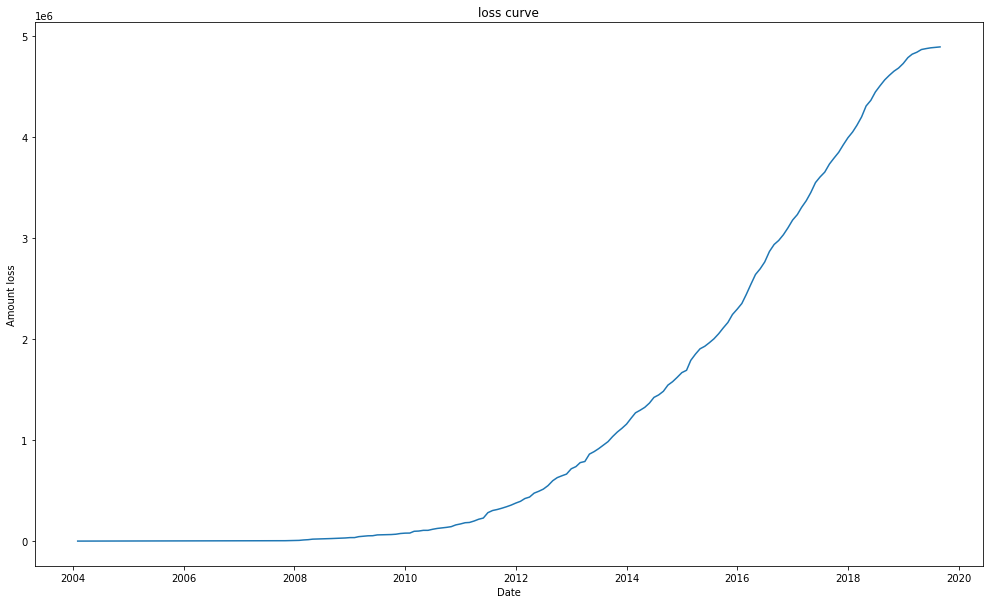

In [ ]:
df.D_DATE = pd.to_datetime(df.D_DATE)
df_sort = df.groupby('D_DATE').DVAL.sum().reset_index()
df_sort['DSUM'] = df_sort['DVAL'].cumsum()

plt.figure(figsize=(17,10))
sns.lineplot(df_sort.D_DATE, df_sort.DSUM)
plt.xlabel('Date')
plt.ylabel('Amount loss')
plt.title("loss curve")

From the graph above we can see that since 2011-2012 the number of defaulted loans has started to increase, and it is very likely that this is linked to an increase in the number of total loans, as we can see in the barplot below which represents year and number of given loans.

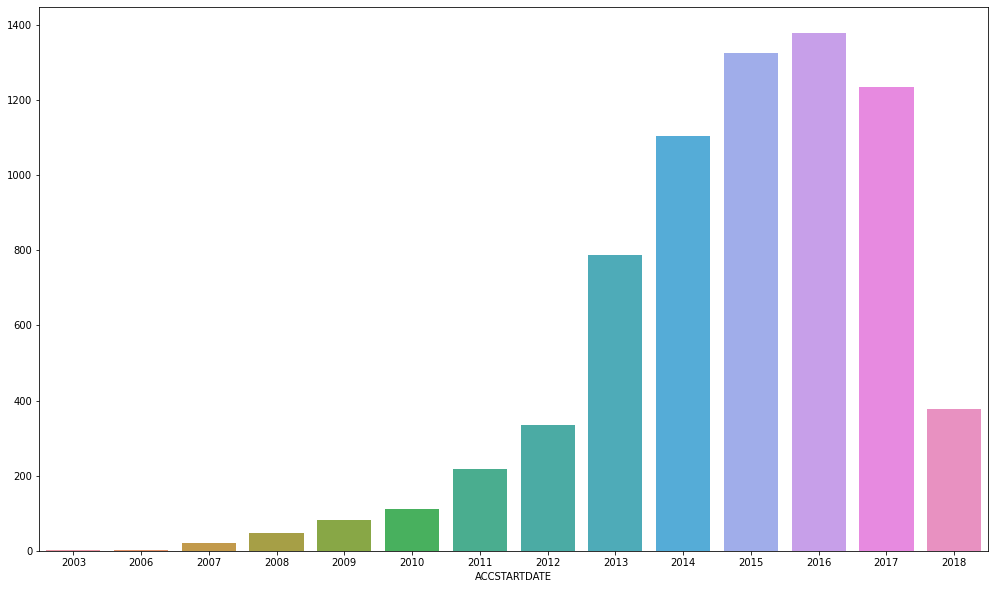

In [ ]:
plt.figure(figsize=(17,10))
sns.barplot(df['ACCSTARTDATE'].groupby([df.ACCSTARTDATE.dt.year]).agg('count').index, df['ACCSTARTDATE'].groupby([df.ACCSTARTDATE.dt.year]).agg('count').values)

### Paydown balance curve

In [ ]:
def new_pd(acc_start, dval, repay, open_balance, dmon):
    paydown = pd.DataFrame(columns=['PAYMENT_DATE', 'AMOUNT'])
    if pd.isnull(dval):
        date = acc_start
        n = np.int(repay)
        debt = open_balance
        month_pay = round(debt/n, 2)

        for k in range(n):
            #dt = datetime.strptime(str(date), '%Y-%m-%d')
            dt = datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S')
            dt+= relativedelta(months=k)

            new_row = {
                'PAYMENT_DATE' : dt,
                'AMOUNT' : month_pay
            }

            paydown = paydown.append(new_row, ignore_index=True)
        return paydown
    
    else:
        date = acc_start
        n = np.int(repay)
        debt = open_balance
        month_pay = round(debt/n, 2)
        N = np.int(dmon)-1 # -1 because customer didnt pay last month monthly payment 

        for k in range(N):
            #dt = datetime.strptime(str(date), '%Y-%m-%d')
            dt = datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S')
            dt+= relativedelta(months=k)

            new_row = {
                'PAYMENT_DATE' : dt,
                'AMOUNT' : month_pay
            }

            paydown = paydown.append(new_row, ignore_index=True)
        return paydown


In [ ]:
df['REPAYPERIOD'] = pd.to_numeric(df['REPAYPERIOD'])

paydown = pd.DataFrame(columns=['PAYMENT_DATE', 'AMOUNT']) # create empty dataframe
df['REPAYPERIOD'] = df['REPAYPERIOD'].apply(lambda x: int(x)) # change repay period to object type
for _, x in df.iterrows(): 
    tmp = new_pd(x.ACCSTARTDATE, x.DVAL, x.REPAYPERIOD, x.OPENBALANCE, x.DMON)
    paydown = pd.concat([paydown, tmp], axis=0)

paydown.PAYMENT_DATE = pd.to_datetime(paydown.PAYMENT_DATE)
df_paydown = paydown.groupby('PAYMENT_DATE').AMOUNT.sum().reset_index()
df_paydown['TOTAL'] = df_paydown['AMOUNT'].cumsum()

Text(0.5, 1.0, 'Paydown curve')

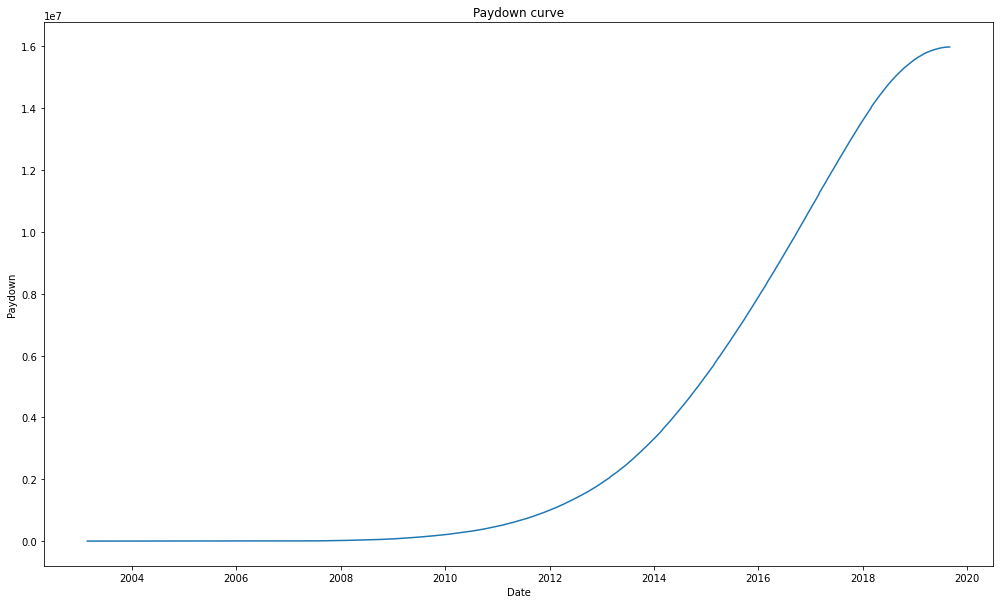

In [ ]:
plt.figure(figsize=(17,10))
sns.lineplot(df_paydown.PAYMENT_DATE, df_paydown.TOTAL)
plt.xlabel('Date')
plt.ylabel('Paydown')
plt.title("Paydown curve")

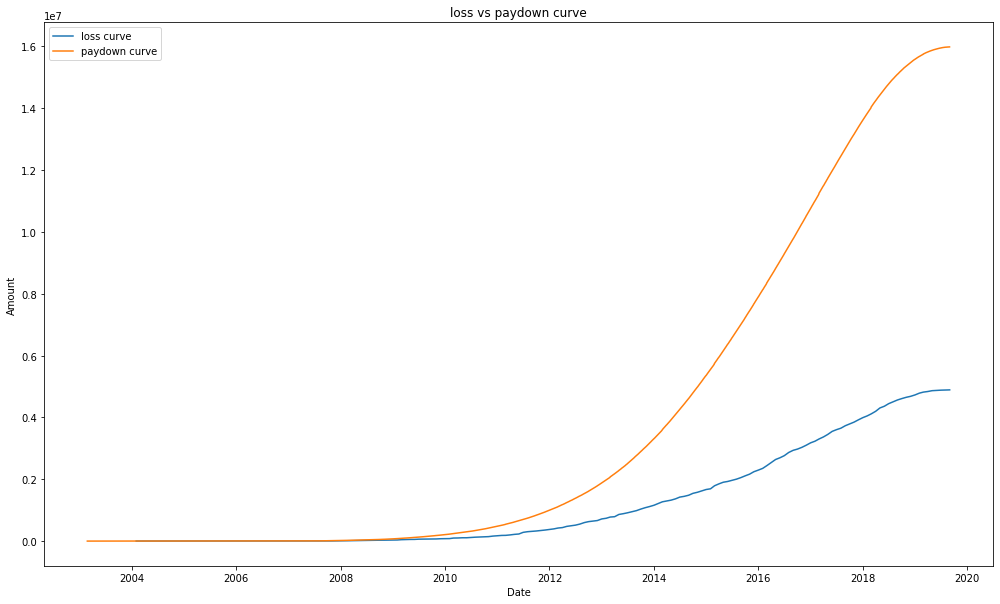

In [ ]:
#%matplotlib notebook
plt.figure(figsize=(17,10))
plt.plot(df_sort.D_DATE, df_sort.DSUM, label='loss curve')
plt.plot(df_paydown.PAYMENT_DATE, df_paydown.TOTAL, label='paydown curve')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.title("loss vs paydown curve")
plt.legend(loc="upper left")

## Customer risk profile
I used the k-means clustering algorithm to perform this task. After segmenting the customers into groups, I looked for what makes these groups special and how they differ from each other.

First of all, our feature vector contains both continuous and categorical data, so we need standardisation, for this I used the sklearn package's function *StandrdScaler*. But before that we need to encode our textual data into numeric data, for this I also use the sklearn package function *LabelEncoder*

The next step, we need to determine the optimal number of clusters **k**. For this, I used the "elbow" method and the silhouette score.


In [ ]:
# encode variables that contains str type
enc = LabelEncoder()

X['CLASS'] = enc.fit_transform(X['CLASS'])
X['ACTIVE_CREDIT'] = enc.fit_transform(X['ACTIVE_CREDIT'])
X['PAST_DEFAULT'] = enc.fit_transform(X['PAST_DEFAULT'])
X['OPEN_BALANCE_CAT'] = enc.fit_transform(X['OPEN_BALANCE_CAT'])

#Y = enc.fit_transform(Y)

X.head()

,REPAYPERIOD,CLASS,ACTIVE_CREDIT,PAST_DEFAULT,OPEN_BALANCE_CAT,SCORE,MONTHLY_PAYMENT
4,60.0,1,0,0,3,599.0,200.00
5,36.0,1,0,0,2,580.0,83.33
6,36.0,1,1,1,2,580.0,83.33
7,36.0,1,0,0,2,662.0,48.36
8,12.0,0,0,0,2,512.0,18.42


In [ ]:
# do scaling
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

X_std

array([[ 2.52713406,  0.69415887, -0.25026461, ...,  1.90271668,
        -0.01267301,  0.98603279],
       [ 0.70934959,  0.69415887, -0.25026461, ...,  0.39513834,
        -0.33500741, -0.10577303],
       [ 0.70934959,  0.69415887,  3.99577071, ...,  0.39513834,
        -0.33500741, -0.10577303],
       ...,
       [-0.19954265,  0.69415887, -0.25026461, ...,  0.39513834,
         1.20880474, -0.73585176],
       [ 2.52713406,  0.69415887, -0.25026461, ..., -2.62001833,
         1.34452449,  0.67609357],
       [-0.19954265, -1.44059241, -0.25026461, ...,  0.39513834,
         0.68289071, -0.65162915]])

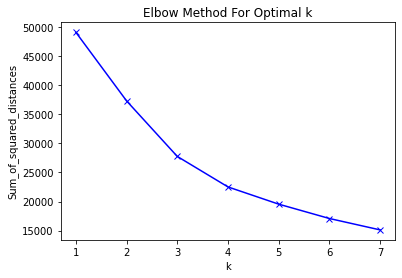

For n_clusters = 2, silhouette score is 0.5819662290399622)
For n_clusters = 3, silhouette score is 0.3822196411265741)
For n_clusters = 4, silhouette score is 0.34401283604368416)
For n_clusters = 5, silhouette score is 0.3300524123381299)
For n_clusters = 6, silhouette score is 0.3442587125189554)
For n_clusters = 7, silhouette score is 0.3664471369025365)


([<matplotlib.axis.XTick at 0x7f5e7c7f2ed0>,
 [Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5'),
  Text(0, 0, '6'),
  Text(0, 0, '7')])

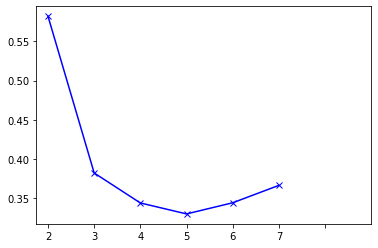

In [ ]:
Sum_of_squared_distances = []
K = range(1,8)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_std)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


ss = []
for n_clusters in range(2,8):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X_std)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X_std, preds)
    ss.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
  
plt.plot(ss, 'bx-')
plt.xticks(np.arange(2, 8))
plt.xticks(np.arange(7), np.arange(2,8))


Both methods sugests k=3

In [ ]:
clt = KMeans(n_clusters=3, random_state=0)
model = clt.fit(X_std)

Since our data is multidimensional, it requires a certain algorithm for dimensionality reduction, in this work I used the TSNE algorithm

In [ ]:
tsne_2d = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne_2d.fit_transform(X_std)
        
trans_data = tsne_2d.fit_transform(X_std)

x = trans_data[:,0]
y = trans_data[:,1]

X = X.assign(PROFILE=model.labels_) # assign labels made by clusters
X.head()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7024 samples in 0.036s...
[t-SNE] Computed neighbors for 7024 samples in 0.604s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7024
[t-SNE] Computed conditional probabilities for sample 2000 / 7024
[t-SNE] Computed conditional probabilities for sample 3000 / 7024
[t-SNE] Computed conditional probabilities for sample 4000 / 7024
[t-SNE] Computed conditional probabilities for sample 5000 / 7024
[t-SNE] Computed conditional probabilities for sample 6000 / 7024
[t-SNE] Computed conditional probabilities for sample 7000 / 7024
[t-SNE] Computed conditional probabilities for sample 7024 / 7024
[t-SNE] Mean sigma: 0.099154
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.810379
[t-SNE] KL divergence after 300 iterations: 1.610241
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7024 samples in 0.028s...
[t-SNE] Computed neighbors for 7024 samples in 0.715s...
[t-SNE] Computed conditional

,REPAYPERIOD,CLASS,ACTIVE_CREDIT,PAST_DEFAULT,OPEN_BALANCE_CAT,SCORE,MONTHLY_PAYMENT,PROFILE
4,60.0,1,0,0,3,599.0,200.00,0
5,36.0,1,0,0,2,580.0,83.33,0
6,36.0,1,1,1,2,580.0,83.33,2
7,36.0,1,0,0,2,662.0,48.36,0
8,12.0,0,0,0,2,512.0,18.42,0


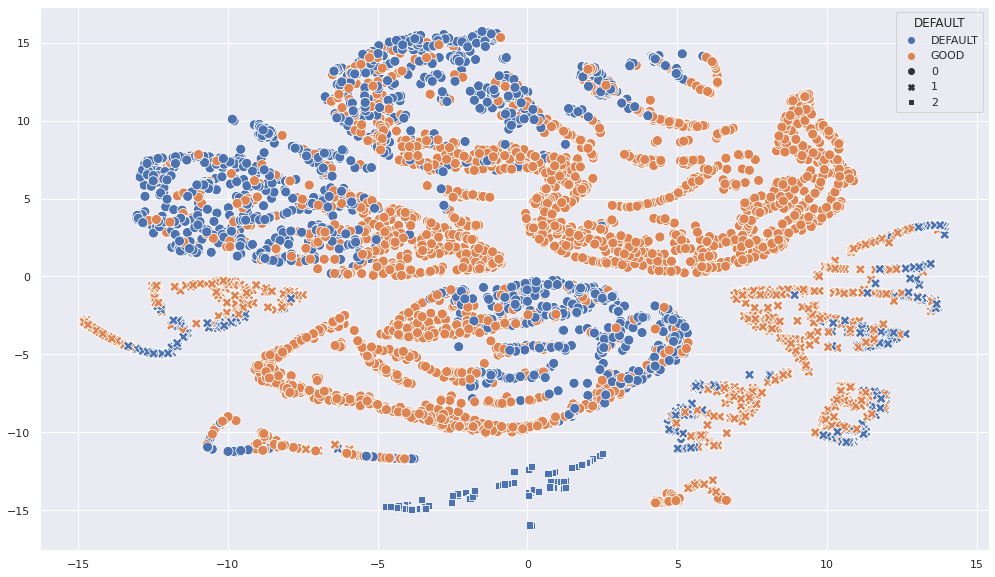

In [ ]:
sns.set(rc={'figure.figsize':(17,10)})
sns.scatterplot(x,y, hue=Y, style=model.labels_, s=100) 

After performing tsne dimension reduction, on the bottom of the plot (shown above) there is group of records that a clearly distinguished (blue squares on the left side), all these records have defaulted status.

In [ ]:
tst = pd.concat([X, Y], axis=1)
tst.head()

,REPAYPERIOD,CLASS,ACTIVE_CREDIT,PAST_DEFAULT,OPEN_BALANCE_CAT,SCORE,MONTHLY_PAYMENT,PROFILE,DEFAULT
4,60.0,1,0,0,3,599.0,200.00,0,DEFAULT
5,36.0,1,0,0,2,580.0,83.33,0,DEFAULT
6,36.0,1,1,1,2,580.0,83.33,2,DEFAULT
7,36.0,1,0,0,2,662.0,48.36,0,GOOD
8,12.0,0,0,0,2,512.0,18.42,0,DEFAULT


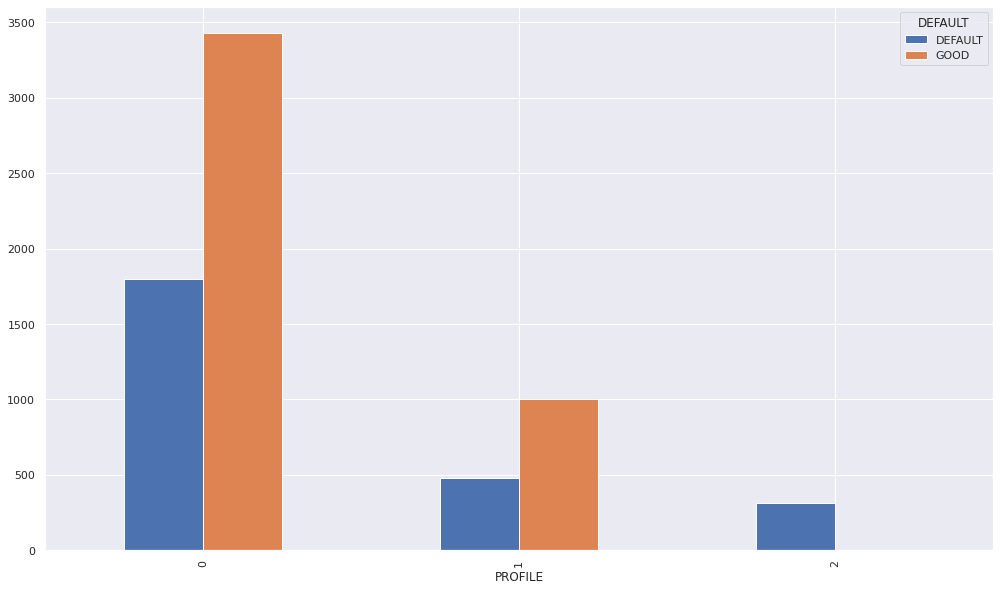

In [ ]:
pd.crosstab(tst['PROFILE'], tst['DEFAULT']).plot.bar()

**Records that belong to category=0:**

This group is quite reliable, perhaps I would even say the most reliable of the three, customers in this group have not defaulted on loans in the past, and at the time of the application for a new loan have usually not defaulted on any obligations. The loans are usually larger and the repayments are consequently higher, perhaps suggesting that they are car loans or perhaps for business development. In short, this group is the most reliable.


**Records that belong to category=1:**

Customers in this group usually have no other debts on the day they apply for a personal loan, and have never had any difficulties repaying the loan before. The most common amount borrowed is over 600, for a period of 2-3 years.
Although these customers seem to be quite reliable, they should be looked at more carefully, as, especially those who borrow small amounts for longer periods of time.


**Records that belong to category=2:**

It is recommended not to give a loan to customers in this group, as all customers in this group have failed to repay their loan on time. And almost all of them already had active loans.





In [ ]:
X[X.PROFILE==0].describe()

,CLASS,ACTIVE_CREDIT,PAST_DEFAULT,OPEN_BALANCE_CAT,SCORE,MONTHLY_PAYMENT,PROFILE
count,5232.000000,5232.000000,5232.0,5232.000000,5232.000000,5232.000000,5232.0
mean,0.676032,0.018731,0.0,2.045107,597.308677,60.266969,0.0
std,0.468033,0.135586,0.0,0.207559,58.925656,67.719693,0.0
min,0.000000,0.000000,0.0,2.000000,473.000000,2.330000,0.0
25%,0.000000,0.000000,0.0,2.000000,546.000000,20.000000,0.0
50%,1.000000,0.000000,0.0,2.000000,591.000000,32.580000,0.0
75%,1.000000,0.000000,0.0,2.000000,649.000000,79.170000,0.0
max,1.000000,1.000000,0.0,3.000000,724.000000,565.580000,0.0


In [ ]:
df[df.index.isin(X[X.PROFILE==0].index)].describe()

,DVAL,DMON,OPENBALANCE,SEARCHDATE,SCORE,MONTHLY_PAYMENT
count,1799.000000,1799.000000,5232.000000,5.232000e+03,5232.000000,5232.000000
mean,1247.939967,14.541968,1519.203555,2.018476e+07,597.308677,60.266969
std,1911.391053,9.553566,2628.903328,6.801133e+03,58.925656,67.719693
min,6.000000,2.000000,72.000000,2.017010e+07,473.000000,2.330000
25%,332.000000,8.000000,480.000000,2.018053e+07,546.000000,20.000000
50%,664.000000,12.000000,720.000000,2.019012e+07,591.000000,32.580000
75%,1391.000000,19.000000,1340.250000,2.019062e+07,649.000000,79.170000
max,20192.000000,70.000000,14999.000000,2.019093e+07,724.000000,565.580000


In [ ]:
X[X.PROFILE==1].describe()

,CLASS,ACTIVE_CREDIT,PAST_DEFAULT,OPEN_BALANCE_CAT,SCORE,MONTHLY_PAYMENT,PROFILE
count,1481.000000,1481.000000,1481.0,1481.000000,1481.000000,1481.000000,1481.0
mean,0.682647,0.017556,0.0,0.626604,620.118839,219.537643,1.0
std,0.465603,0.131374,0.0,0.550498,54.721760,129.793104,0.0
min,0.000000,0.000000,0.0,0.000000,494.000000,64.350000,1.0
25%,0.000000,0.000000,0.0,0.000000,574.000000,138.920000,1.0
50%,1.000000,0.000000,0.0,1.000000,623.000000,187.110000,1.0
75%,1.000000,0.000000,0.0,1.000000,667.000000,252.060000,1.0
max,1.000000,1.000000,0.0,3.000000,721.000000,1249.920000,1.0


In [ ]:
df[df.index.isin(X[X.PROFILE==1].index)].describe()

,DVAL,DMON,OPENBALANCE,SEARCHDATE,SCORE,MONTHLY_PAYMENT
count,481.000000,481.000000,1481.000000,1.481000e+03,1481.000000,1481.000000
mean,4459.866944,20.625780,7202.568535,2.018330e+07,620.118839,219.537643
std,2502.448169,12.897564,2220.006563,7.294487e+03,54.721760,129.793104
min,117.000000,2.000000,3813.000000,2.017010e+07,494.000000,64.350000
25%,2769.000000,11.000000,5045.000000,2.018032e+07,574.000000,138.920000
50%,4121.000000,18.000000,7102.000000,2.018103e+07,623.000000,187.110000
75%,5937.000000,27.000000,9000.000000,2.019052e+07,667.000000,252.060000
max,14963.000000,69.000000,14999.000000,2.019093e+07,721.000000,1249.920000


In [ ]:
X[X.PROFILE==2].describe()

,CLASS,ACTIVE_CREDIT,PAST_DEFAULT,OPEN_BALANCE_CAT,SCORE,MONTHLY_PAYMENT,PROFILE
count,311.000000,311.000000,311.0,311.000000,311.000000,311.000000,311.0
mean,0.617363,0.932476,1.0,1.861736,543.755627,77.971865,2.0
std,0.486814,0.251332,0.0,0.535979,24.702973,78.588220,0.0
min,0.000000,0.000000,1.0,0.000000,484.000000,4.170000,2.0
25%,0.000000,1.000000,1.0,2.000000,526.500000,25.000000,2.0
50%,1.000000,1.000000,1.0,2.000000,541.000000,50.000000,2.0
75%,1.000000,1.000000,1.0,2.000000,558.000000,105.545000,2.0
max,1.000000,1.000000,1.0,3.000000,621.000000,555.560000,2.0


In [ ]:
df[df.index.isin(X[X.PROFILE==2].index)].describe()

,DVAL,DMON,OPENBALANCE,SEARCHDATE,SCORE,MONTHLY_PAYMENT
count,311.000000,311.000000,311.000000,3.110000e+02,311.000000,311.000000
mean,1604.942122,14.649518,2197.144695,2.018681e+07,543.755627,77.971865
std,2426.766551,9.885603,3083.208980,5.837779e+03,24.702973,78.588220
min,4.000000,3.000000,73.000000,2.017010e+07,484.000000,4.170000
25%,333.000000,8.000000,499.500000,2.018097e+07,526.500000,25.000000
50%,688.000000,11.000000,888.000000,2.019042e+07,541.000000,50.000000
75%,1810.000000,19.500000,2100.000000,2.019072e+07,558.000000,105.545000
max,20426.000000,64.000000,14865.000000,2.019093e+07,621.000000,555.560000


# Default Classifier
Before starting any classification we need to split our dataset into train ant test parts

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_std, Y, test_size=0.2, random_state=144)

In [ ]:
clf = LogisticRegression(C=1,penalty='l2', solver='newton-cg', class_weight={'DEFAULT': 0.2, 'GOOD': 0.8}) # quadratic penalty | class_weight added!

# Creating the model on Training Data
LOG=clf.fit(X_train,y_train)
prediction=LOG.predict(X_test)

# Measuring accuracy on x_test
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))


# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(LOG, X_std , Y, cv=10, scoring='f1_weighted')

print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))

              precision    recall  f1-score   support

     DEFAULT       0.87      0.41      0.55       535
        GOOD       0.73      0.96      0.83       870

    accuracy                           0.75      1405
   macro avg       0.80      0.68      0.69      1405
weighted avg       0.78      0.75      0.72      1405

[[218 317]
 [ 33 837]]
Accuracy of the model on Testing Sample Data: 0.72

Accuracy values for 10-fold Cross Validation:
 [0.75719609 0.74197931 0.72683691 0.75717954 0.74847877 0.73269356
 0.73843737 0.73959232 0.70466722 0.67643688]

Final Average Accuracy of the model: 0.73


### Assign default probability for each record

In [ ]:
df = df.assign(DEFAULT_PROB=LOG.predict_proba(X_std)[:,0].round(3)) # assign labels made by clusters
df.head()

,UID,RECORDNUMBER,DVAL,DMON,OPENBALANCE,ACCSTARTDATE,FIRST_MONTH,LAST_MONTH,REPAYPERIOD,SEARCHDATE,SCORE,CLASS,DEFAULT,REPAY_DATE,D_DATE,ACTIVE_CREDIT,PAST_DEFAULT,MONTHLY_PAYMENT,OPEN_BALANCE_CAT,DEFAULT_PROB
4,225b6f92-6c66-45c1-bb82-7ed89aad9619,8,7859.0,27.0,12000.0,2012-11-13,2013-08-01,2019-07-01,60.0,20190717,599.0,STANDARD,DEFAULT,2017-11-13,2015-02,CLEAR,CLEAR,200.00,VERY LARGE,0.200
5,d10af710-591d-458e-b81f-85fb99d9c5a8,9,2739.0,9.0,3000.0,2012-09-22,2012-09-01,2018-08-01,36.0,20180824,580.0,STANDARD,DEFAULT,2015-09-22,2013-06,CLEAR,CLEAR,83.33,SMALL,0.160
6,d10af710-591d-458e-b81f-85fb99d9c5a8,10,2680.0,9.0,3000.0,2012-08-26,2012-09-01,2018-08-01,36.0,20180824,580.0,STANDARD,DEFAULT,2015-08-26,2013-05,HAVE LOAN,DEFAULTED,83.33,SMALL,0.985
7,6457c750-e7c0-4309-9ca3-8dd2ddbabbc0,8,NaN,NaN,1741.0,2016-05-09,2016-06-01,2019-06-01,36.0,20190713,662.0,STANDARD,GOOD,2019-05-09,NaN,CLEAR,CLEAR,48.36,SMALL,0.005
8,d09b7e2a-b602-45bb-9882-e4af4d0e07c2,14,221.0,7.0,221.0,2017-06-29,2018-10-01,2019-06-01,12.0,20190608,512.0,PREMIUM,DEFAULT,2018-06-29,2018-01,CLEAR,CLEAR,18.42,SMALL,0.620


# Conclusion

I have come to the following conclusions after completing this task:

1. The data provided is very poor quality, there were many missing values, some rows had no logic at all, e.g. the OPENBALANCE variable had a value of 0 and at the same time it was defined as DEFAULT with the value greater than 0 in DVAL.
2. As the data was very limited, it was necessary to create our own variables, such as whether the user has an active loan, whether he has already defaulted on the loan and other secondary variables.

3. After statistical tests, I have identified the variables that are related with our target variable.

4. After selecting the statistically significant variables, I constructed a logistic regression classification model with an accuracy of ~85%.

5. For the available observations (original dataset), I derived the probability that the loan will be defaulted.

Further research could be done using other scaling methods and other classification methods such as Naive Bayesian classifier, Decision Tree, Random Forest and others.

In [ ]:
#%%shell
#jupyter nbconvert --to html /content/credit_modeller_.ipynb